In [50]:
import pandas as pd
import numpy as np

import torch
from torch import nn

from sklearn.preprocessing import MinMaxScaler # for normalizing the data
from tqdm.notebook import tqdm # for the progress bar

import matplotlib.pyplot as plt
import plotly.graph_objects as go
device = 'cpu'

In [51]:
BATCH_SIZE = 256
EPOCHS = 1000
WINDOW_SIZE = 40

In [70]:
df = pd.read_csv('data/TATASTEEL.csv')

In [71]:
df.head(10)

,Date,Open,High,Low,Close,Volume
0,2005-10-17,380.00,386.30,374.60,384.35,4618966
1,2005-10-18,386.85,388.55,364.10,374.85,3408087
2,2005-10-19,371.60,373.55,352.00,361.55,4549667
3,2005-10-20,365.30,371.85,351.50,358.60,4132203
4,2005-10-21,360.35,368.50,357.65,367.40,4355886
5,2005-10-24,368.50,379.90,350.80,352.30,3894076
6,2005-10-25,355.00,357.50,348.00,350.50,4574872
7,2005-10-26,351.00,355.90,344.30,346.90,4196216
8,2005-10-27,347.60,348.85,335.10,337.60,5109854
9,2005-10-28,348.85,348.90,329.00,330.80,2394522


In [72]:
# Normalizing the data
scaler = MinMaxScaler(feature_range=(-1, 1))
# Min and max of the close price
print(df['Close'].min(), df['Close'].max())
df['Close'] = scaler.fit_transform(df['Close'].values.reshape(-1,1))
# mean and std of the close price
df.head(10)
# # Converting the numpy array to torch tensors
# data = torch.FloatTensor(normalized_df).view(-1)

148.8 988.9


,Date,Open,High,Low,Close,Volume
0,2005-10-17,380.00,386.30,374.60,-0.439233,4618966
1,2005-10-18,386.85,388.55,364.10,-0.461850,3408087
2,2005-10-19,371.60,373.55,352.00,-0.493513,4549667
3,2005-10-20,365.30,371.85,351.50,-0.500536,4132203
4,2005-10-21,360.35,368.50,357.65,-0.479586,4355886
5,2005-10-24,368.50,379.90,350.80,-0.515534,3894076
6,2005-10-25,355.00,357.50,348.00,-0.519819,4574872
7,2005-10-26,351.00,355.90,344.30,-0.528389,4196216
8,2005-10-27,347.60,348.85,335.10,-0.550530,5109854
9,2005-10-28,348.85,348.90,329.00,-0.566718,2394522


In [61]:
class StockDataset(torch.utils.data.Dataset):
    def __init__(self, df, window_size=WINDOW_SIZE):
        self.df = df
        self.window_size = window_size
        self.data = df['Close'].values

    def __len__(self):
        return len(self.data) - self.window_size

    def __getitem__(self, idx):
        x = torch.tensor(self.data[idx:idx+self.window_size]).unsqueeze(-1).float()
        y = torch.tensor(self.data[idx+1:idx+self.window_size+1]).unsqueeze(-1).float()
        return x, y
    
dataset = StockDataset(df)

In [62]:
dataset[4]

(tensor([[-0.4796],
         [-0.5155],
         [-0.5198],
         [-0.5284],
         [-0.5505],
         [-0.5667],
         [-0.5462],
         [-0.5445],
         [-0.5235],
         [-0.4885],
         [-0.4922],
         [-0.4907],
         [-0.4892],
         [-0.4703],
         [-0.4839],
         [-0.4792],
         [-0.4804],
         [-0.4729],
         [-0.4953],
         [-0.5184],
         [-0.5385],
         [-0.5391],
         [-0.5395],
         [-0.5348],
         [-0.5335],
         [-0.5260],
         [-0.5217],
         [-0.5203],
         [-0.5042],
         [-0.5112],
         [-0.5183],
         [-0.5217],
         [-0.5265],
         [-0.5066],
         [-0.4899],
         [-0.4745],
         [-0.4540],
         [-0.4761],
         [-0.4784],
         [-0.4495]]),
 tensor([[-0.5155],
         [-0.5198],
         [-0.5284],
         [-0.5505],
         [-0.5667],
         [-0.5462],
         [-0.5445],
         [-0.5235],
         [-0.4885],
         [-0.4922]

In [63]:
# Train test split
train_size = int(len(dataset) * 0.8)
test_size = len(dataset) - train_size

train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

In [64]:
train_dataset.__len__(), test_dataset.__len__()

(2967, 742)

In [65]:
# # Data loader
# train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
# test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [4]:
class StockPredictor(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers=1):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, 1)
        
    def forward(self, x):
        # print('x', x.shape)
        out, _ = self.lstm(x) # out: tensor of shape (batch_size, seq_length, hidden_size)
        # print('out1', out.shape, out)
        out = self.linear(out) # out: tensor of shape (batch_size, output_size)
        # print('out2', out.shape, out)
        return out

NameError: name 'nn' is not defined

In [67]:
model = StockPredictor(input_size=1, hidden_size=16, num_layers=4)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.MSELoss()

# # Overfit a single batch
# for epoch in range(1000):
#     x, y = dataset[0]
#     model.train()
#     y_pred = model(torch.tensor(x).unsqueeze(-1).float())
#     print('y_pred', y_pred)
#     print('y', y)
#     # break
#     optimizer.zero_grad()
#     loss = loss_fn(y_pred.squeeze(), torch.tensor(y).float())
#     loss.backward()
#     optimizer.step()
#     print(f'Epoch: {epoch}, Loss: {loss.item():.4f}')

In [68]:
losses = []

In [72]:
# Training loop
model.to(device)

for epoch in tqdm(range(10000)):
    model.train()
    loss = 0
    for _ in range(BATCH_SIZE):
        ranint = np.random.randint(0, len(train_dataset))
        x, y = train_dataset[ranint]
        y_pred = model(x.to(device))
        loss += loss_fn(y_pred, y.to(device))
    optimizer.zero_grad() 
    loss.backward()
    optimizer.step()
    losses.append(loss.item())
    
    if epoch % 10 == 0:
        print(f'Epoch: {epoch+1}, Loss: {loss.item()/BATCH_SIZE:.4f}')
        # print('y_pred', y_pred)
        # print('y', y)
        print('-'*20)

  0%|          | 0/10000 [00:00<?, ?it/s]

Epoch: 1, Loss: 0.0150
--------------------
Epoch: 11, Loss: 0.0177
--------------------
Epoch: 21, Loss: 0.0168
--------------------
Epoch: 31, Loss: 0.0147
--------------------
Epoch: 41, Loss: 0.0143
--------------------
Epoch: 51, Loss: 0.0121
--------------------
Epoch: 61, Loss: 0.0124
--------------------
Epoch: 71, Loss: 0.0123
--------------------
Epoch: 81, Loss: 0.0120
--------------------
Epoch: 91, Loss: 0.0120
--------------------
Epoch: 101, Loss: 0.0112
--------------------
Epoch: 111, Loss: 0.0111
--------------------
Epoch: 121, Loss: 0.0119
--------------------
Epoch: 131, Loss: 0.0097
--------------------
Epoch: 141, Loss: 0.0106
--------------------
Epoch: 151, Loss: 0.0103
--------------------
Epoch: 161, Loss: 0.0096
--------------------
Epoch: 171, Loss: 0.0100
--------------------
Epoch: 181, Loss: 0.0094
--------------------
Epoch: 191, Loss: 0.0095
--------------------
Epoch: 201, Loss: 0.0085
--------------------
Epoch: 211, Loss: 0.0081
--------------------

KeyboardInterrupt: 

In [73]:
torch.save(model.state_dict(), 'models/lstm_stock_predictor_v4.pt')

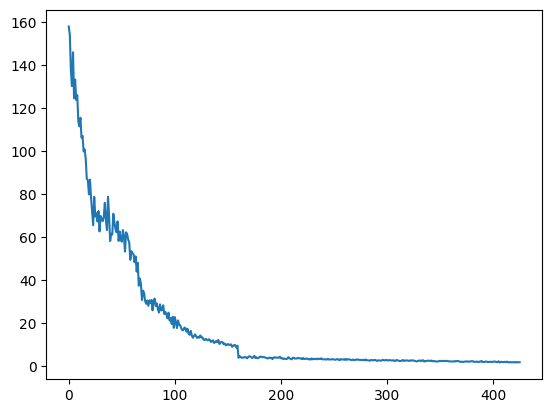

In [74]:
plt.plot(losses)

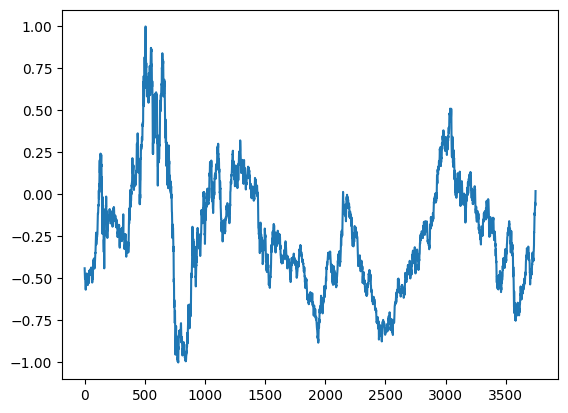

In [76]:
plt.plot(df['Close'], label='Actual')

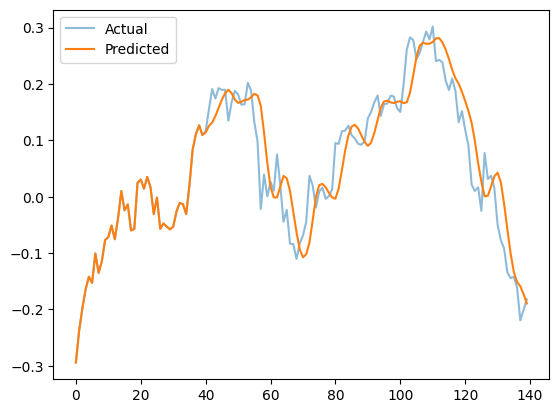

In [79]:
model.eval()
N = 1000
pred_len = 100
predictions = df['Close'].values[N:N+WINDOW_SIZE].tolist()

with torch.no_grad():
    for i in range(pred_len):
        x = torch.tensor(df['Close'].values[N+i:N+WINDOW_SIZE+i]).unsqueeze(-1).float().to(device)
        predictions.append(model(x)[-1].item())
    
plt.plot(df['Close'].values[N:N+WINDOW_SIZE+pred_len], label='Actual', alpha=0.5)
plt.plot(predictions, label='Predicted')
plt.legend()

# Calculating Returns


In [18]:
import gym
import gym_anytrading
import pandas as pd
import numpy as np
import torch
from torch import nn

In [168]:
class StockPredictor(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers=1):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, 1)
        
    def forward(self, x):
        # print('x', x.shape)
        out, _ = self.lstm(x) # out: tensor of shape (batch_size, seq_length, hidden_size)
        # print('out1', out.shape, out)
        out = self.linear(out) # out: tensor of shape (batch_size, output_size)
        # print('out2', out.shape, out)
        return out
    
    def predict(self, x): # To buy or to sell, x: tensor of shape (seq_length, 1)
        last_price = x[-1,0]
        x = torch.tensor(x[:, 0]).unsqueeze(0).unsqueeze(-1).float()
        with torch.no_grad():
            pred = model(x)[:, -1, :].squeeze().item()
            # print('pred', pred, 'last_price', last_price)
            if pred > last_price: # Buy, price will go up
                return 0 # Buy
            else:
                return 1

In [169]:
WINDOW_SIZE = 40
df = pd.read_csv('data/TATASTEEL.csv')

In [170]:
model = StockPredictor(input_size=1, hidden_size=16, num_layers=4)
model.load_state_dict(torch.load('models/lstm_stock_predictor_v4.pt'))

<All keys matched successfully>

In [196]:
START_INDEX = 3600
TEST_LENGTH = 100
test_env = gym.make('stocks-v0', df=df, window_size=WINDOW_SIZE,frame_bound=(START_INDEX+ WINDOW_SIZE, START_INDEX+WINDOW_SIZE+TEST_LENGTH))

In [197]:
obs = test_env.reset()
# torch.tensor(obs[:, 0]).unsqueeze(0).unsqueeze(-1).float().shape

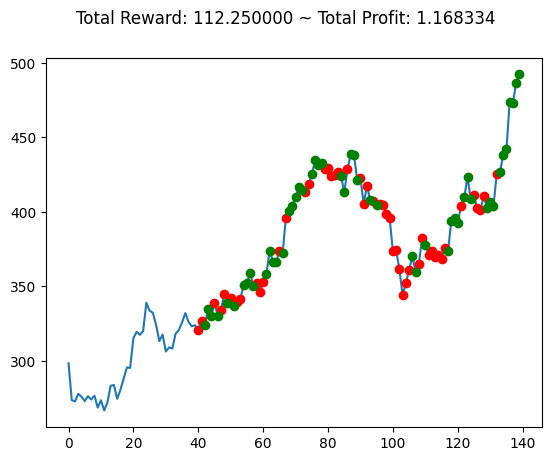

In [198]:
obs = test_env.reset()
# print(test_env.max_possible_profit())

while True:
    action = model.predict((obs-568.85)/420.05)
    obs, rewards, done, info = test_env.step(action)
    if done:
        test_env.render_all()
        break